Cosmology (compact) SS2020

# Exercise 4

## 2. Build your own Cosmological Calculator (Part III)

Plot the (linear) power spectrum $P(k, z)$ at $z = 0, 1, 4$

Plot the mass variance of the linear density field $\sigma (M, z)$ at $z = 0, 1, 4$

In [11]:
import astropy.constants as cst
import scipy.integrate as intg
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

h = 0.67
H0 = 100*h # km/s /Mpc
km_Mpc = (u.km/u.Mpc).to(1)

def a(z):
    return 1/(1+z)

def E(z, dict):
    return np.sqrt(dict["Omega_r0"]*(1+z)**4+dict["Omega_m0"]*(1+z)**3+(1-dict["Omega_m0"]-dict["Omega_L0"]-dict["Omega_r0"])*(1+z)**2+dict["Omega_L0"])

# Hubble factor
def H(z, dict):
    return H0*E(z,dict)
H_vectorized = np.vectorize(H)

# Density parameters
def Omega_m(z, dict):
    return dict["Omega_m0"]*(1+z)**3/E(z, dict)**2
def rho_m(z, dict):
    return Omega_m(z, dict)*(3*(H(z, dict)/km_Mpc)**2/(8*np.pi*cst.G.value))
def Omega_r(z, dict):
    return dict["Omega_r0"]*(1+z)**4/E(z, dict)**2
def Omega_L(z, dict):
    return dict["Omega_L0"]/E(z, dict)**2
def Omega_K(z, dict):
    Omega_K0 = 1-dict["Omega_m0"]-dict["Omega_L0"]-dict["Omega_r0"]
    return Omega_K0*(1+z)**2/E(z, dict)**2
def Omega_b(z, dict):
    return dict["Omega_b0"]*(1+z)**3/E(z, dict)**2

# Growth Factor
def g(z, dict):
    O_m = Omega_m(z, dict)
    O_L = Omega_L(z, dict)
    return 2.5*O_m/(O_m**(4/7)-O_L+(1+O_m/2)*(1+O_L/70))
def D_growth(z, dict):
    return a(z)*g(z, dict)/g(0, dict)

# linear power spectrum
n_S = 1
def BBKS(k, dict):     # transfer function, see https://www.researchgate.net/publication/1899507_Evolution_of_density_perturbations_in_decaying_vacuum_cosmology
    O_b = dict["Omega_b0"]
    Sigma = dict["Omega_m0"]*h*np.exp(-dict["Omega_b0"] - np.sqrt(2*h)*dict["Omega_b0"]/dict["Omega_m0"])
    q = k/(Sigma * h)
    return (np.log(1+2.34*q)/2.34/q)*(1+3.89*q+(16.1*q)**2+(5.46*q)**3+(6.71*q)**4)**(-0.25)
def A(dict):
    R8 = 8/h   # Mpc
    intgrand = lambda k : (k**2)*(k**n_S)*(BBKS(k, dict)**2)*W_TH(k*R8)
    intgr = intg.quad(intgrand, 0, np.inf)[0]
    return (dict["Sigma8"]**2)*2*(np.pi**2)/intgr
def P(k, z, dict):
    return k**n_S*BBKS(k, dict)**2*D_growth(z, dict)**2*A(dict)
P_vectorized = np.vectorize(P)

# mass variance of the linear density field
def W_G(y):     # Window function, Gaussian; see http://www.astro.yale.edu/vdbosch/astro610_lecture9.pdf
    return np.exp(-(y**2)/2)
def sigma_G(R, z, dict):
    intgrand = lambda k: (k**2)*(W_G(k*R)**2)*(k**n_S)*(BBKS(k, dict)**2)
    res = intg.quad(intgrand, 0, np.inf)[0]
    return 1/(2*np.pi**2) * res * D_growth(z, dict)**2 *A(dict)
sigma_G_vectorized = np.vectorize(sigma_G)

def W_TH(y):   # Window function, Top hat
    return 3*(np.sin(y) - y*np.cos(y))/(y**3)
def sigma_TH(R, z, dict):
    intgrand = lambda k: (W_TH(k*R)**2)*(k**2)*(k**n_S)*(BBKS(k, dict)**2)
    res = intg.quad(intgrand, 0, np.inf)[0]
    return 1/(2*np.pi**2) * res * D_growth(z, dict)**2 *A(dict)
sigma_TH_vectorized = np.vectorize(sigma_TH)


# a reference of the variance
# see https://www.slac.stanford.edu/econf/C070730/talks/Wechsler_080207.pdf

Define cosmological parameters for different cosmological scenario.

In [3]:
EdS = {"Omega_m0": 1, "Omega_b0":0.02205*(H0/100)**(-2), "Omega_L0": 0, "Omega_r0": 0}
U2 = {"Omega_m0": 0.3, "Omega_L0": 0, "Omega_r0": 0}
LCDM = {"Omega_m0": 0.315, "Sigma8":0.829, "Omega_b0":0.02205*h**(-2), "Omega_L0": 0.685, "Omega_r0": 2.47*10**(-5)*h**(-2)}

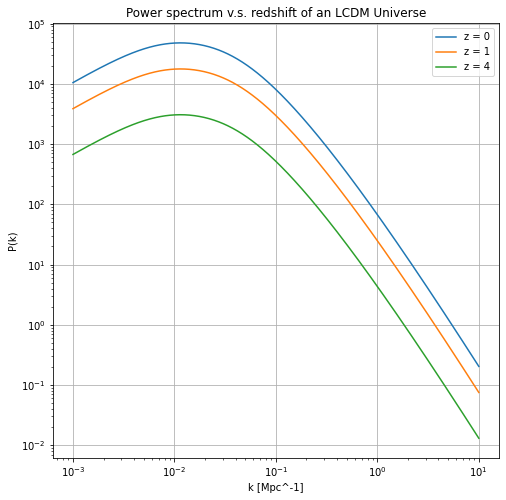

In [15]:
k = np.logspace(-3, 1, num=1000)
plt.figure(figsize = [8, 8])
plt.plot(k, P_vectorized(k, 0, LCDM), label = "z = 0")
plt.plot(k, P_vectorized(k, 1, LCDM), label = "z = 1")
plt.plot(k, P_vectorized(k, 4, LCDM), label = "z = 4")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("k [Mpc^-1]")
plt.ylabel("P(k)")
plt.grid()
plt.title("Power spectrum v.s. redshift of an LCDM Universe")
plt.show()

The power spectrum shows that at large spatial scale (k small) the correlation is weak (P large), at small spatial scale (k large) the correlation is strong (P small). That corresponds our expectation.

We also see that with time moving forward (from large z to small z) the correlation become weaker (P larger).

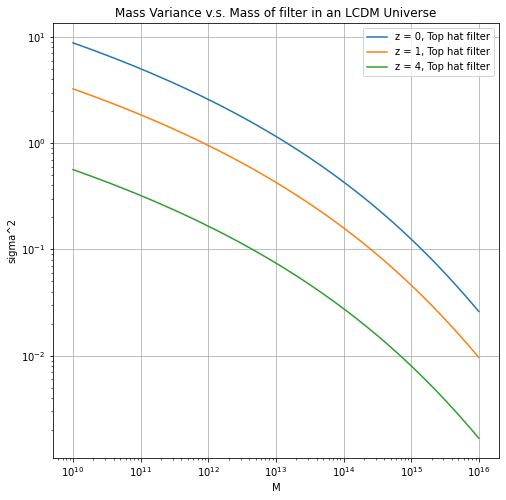

In [14]:
M = np.logspace(10, 16, num=100)
rho_bg = 1e10
R = (M/(rho_bg*np.pi*(4/3)))**(1/3)
plt.figure(figsize = [8, 8])
#plt.plot(M, sigma_G_vectorized(R, 0, LCDM), label = "z = 0, Gaussian filter")
#plt.plot(M, sigma_G_vectorized(R, 1, LCDM), label = "z = 1, Gaussian filter")
#plt.plot(M, sigma_G_vectorized(R, 4, LCDM), label = "z = 4, Gaussian filter")
plt.plot(M, sigma_TH_vectorized(R, 0, LCDM), label = "z = 0, Top hat filter")
plt.plot(M, sigma_TH_vectorized(R, 1, LCDM), label = "z = 1, Top hat filter")
plt.plot(M, sigma_TH_vectorized(R, 4, LCDM), label = "z = 4, Top hat filter")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("M")
plt.ylabel("sigma^2")
plt.grid()
plt.title("Mass Variance v.s. Mass of filter in an LCDM Universe")
plt.show()

We see that with time moving forward (from large z to small z) the mass variance becomes larger.

We also see that the mass variance decreases with increasing mass for filter funciton. 